# SCC0633/SCC5908 - Processamento de Linguagem Natural
> **Docente:** Thiago Alexandre Salgueiro Pardo \\
> **Estagiário PAE:** Germano Antonio Zani Jorge


# Integrantes do Grupo: GPTrouxas
> André Guarnier De Mitri - 11395579 \\
> Daniel Carvalho - 10685702 \\
> Fernando - 11795342 \\
> Lucas Henrique Sant'Anna - 10748521 \\
> Magaly L Fujimoto - 4890582 \\


# Abordagem Neural usando BERT
![alt text](../imagens/BERT_TDIDF.png)

###

## Importando bibliotecas

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
#!pip install transformers seaborn nltk

## Carregando dados

In [3]:
df_reviews = pd.read_csv('imdb_reviews.csv')
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Mapeando as classes
- Sentimento positivo recebe label 1
- Sentimento negativo recebe label 0

In [4]:
def map_sentiments(sentiment):
    if sentiment == 'positive':
        return 1
    return 0

df_reviews['sentiment'] = df_reviews['sentiment'].apply(map_sentiments)
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Funções para limpeza do texto
**lowercase_text(text)** Converte o texto para letras minúsculas para uniformizar o texto.


**remove_html(text)**  Remove quaisquer tags HTML do texto para limpar dados provenientes de fontes HTML.


 **remove_url(text)** Remove URLs do texto para eliminar links que podem não ser relevantes para a análise de texto.


**remove_punctuations(text)** Remove pontuações do texto para simplificar a estrutura do texto, mantendo apenas palavras.

**remove_emojis(text)** Remove emojis do texto para evitar caracteres não verbais que podem interferir na análise textual.

**remove_stop_words(text)** Remove stop words (palavras comuns como "e", "de", "o") que geralmente não adicionam valor significativo à análise de texto.

**stem_words(text)**  Aplica stemming nas palavras do texto, reduzindo-as à sua raiz (por exemplo, "running" vira "run") para normalizar as variações das palavras.

**preprocess_text(text)**  Aplica todas as funções acima em sequência para pré-processar o texto de forma completa, tornando-o mais adequado para análise de texto ou modelagem.





In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def lowercase_text(text):
    return text.lower()

def remove_html(text):
    return re.sub(r'<[^<]+?>', '', text)

def remove_url(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

def remove_punctuations(text):
    tokens_list = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for char in text:
        if char in tokens_list:
            text = text.replace(char, ' ')

    return text

def remove_emojis(text):
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002500-\U00002BEF"
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"
                        u"\u3030"
                        "]+", re.UNICODE)

    text = re.sub(emojis, '', text)
    return text

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    new_text = ''
    for word in text.split():
        if word not in stop_words:
            new_text += ''.join(f'{word} ')

    return new_text.strip()

def stem_words(text):
    stemmer = PorterStemmer()
    new_text = ''
    for word in text.split():
        new_text += ''.join(f'{stemmer.stem(word)} ')

    return new_text

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuations(text)
    text = remove_emojis(text)
    text = remove_stop_words(text)
    text = stem_words(text)

    return text

nltk.download('stopwords')
df_reviews['review'] = df_reviews['review'].apply(preprocess_text)
df_reviews.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,one review mention watch 1 oz episod hook righ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


### Visualizando balancemento da classes

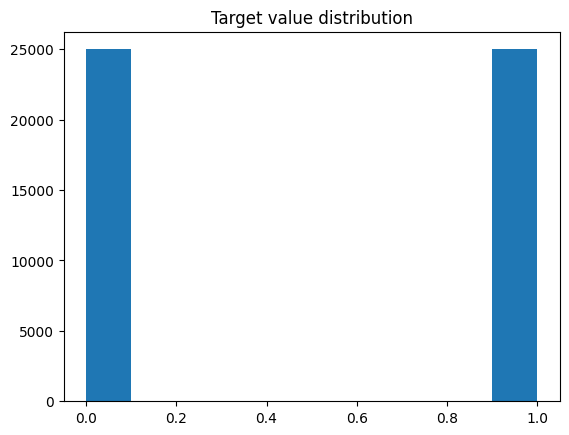

In [6]:
plt.title('Target value distribution')
plt.hist(df_reviews['sentiment'])
plt.show()

# Modelo BERT

## Instalando Bibliotecas

In [4]:
#pip install transformers
#pip install accelerate -U
#pip install transformers[torch]
#pip install datasets evaluate

## Carregando o modelo treinado e tokenizador

In [10]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification

pre_trained_base = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pre_trained_base)
model = BertForSequenceClassification.from_pretrained(pre_trained_base, num_labels = 2, output_attentions=False, output_hidden_states=False)

c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Tokenização das Sentenças e Cálculo do Tamanho dos Tokens

In [13]:
token_lens = []

for sentence in df_reviews['review']:
    tokens = tokenizer.encode(sentence, max_length=200, truncation=True)
    token_lens.append(len(tokens))

### Divisão dos Dados em Conjunto de Treinamento e Validação:

In [15]:
SEED=42
MAX_LEN = 200
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_reviews, test_size=0.2, random_state=SEED)

### Processando os dados
A função process_data recebe uma linha de um dataframe contendo uma revisão de texto e sua respectiva classificação de sentimento. Ela começa extraindo e limpando o texto da revisão, removendo quaisquer espaços extras. Em seguida, utiliza o tokenizer BERT para tokenizar o texto, aplicando padding e truncamento para garantir que todas as sequências tenham um comprimento fixo definido pela variável MAX_LEN. A função então adiciona a etiqueta de sentimento original e o texto limpo às codificações geradas, retornando um dicionário que contém os tokens do texto, a etiqueta de sentimento e o texto original.

In [16]:
def process_data(row):

    text = row['review']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LEN)

    encodings['label'] = row['sentiment']
    encodings['text'] = text

    return encodings

In [17]:
# Treino
processed_data_tr = []
for i in range(df_train.shape[0]):
    processed_data_tr.append(process_data(df_train.iloc[i]))

In [18]:
# Validação
processed_data_val = []
for i in range(df_val.shape[0]):
    processed_data_val.append(process_data(df_val.iloc[i]))

In [19]:
# Dataframes de Treino e Validação
df_train = pd.DataFrame(processed_data_tr)
df_val = pd.DataFrame(processed_data_val)

In [20]:
df_train.head()

,attention_mask,input_ids,label,text,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2921, 3198, 23624, 2954, 6978, 2674, 841...",0,kept ask mani fight scream match swear gener m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3422, 4372, 3775, 2099, 9587, 5737, 2071...",0,watch entir movi could watch entir movi stop d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3543, 2293, 2358, 10050, 2128, 25300, 11...",1,touch love stori reminisc in mood love draw h...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 3732, 2154, 11865, 15472, 2072, 8040, 73...",0,latter day fulci schlocker total abysm concoct...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2034, 3813, 3669, 19337, 2666, 2615, 504...",0,first firmli believ norwegian movi continu get...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Fine Tunning do Modelo
Ajuste fino do BERT para tarefas específica de classificação de sentimento para o dataset do IMDB

In [ ]:
import torch
import pyarrow as pa
from datasets import Dataset
import evaluate
import numpy as np

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
train_hg = Dataset(pa.Table.from_pandas(df_train))
valid_hg = Dataset(pa.Table.from_pandas(df_val))

## Metricas de avaliação F1 Score e Acc

`compute_metrics` calcula tanto a acurácia quanto o F1-score para avaliar um modelo de classificação. Primeiramente, são carregadas as métricas de acurácia e F1-score usando evaluate.load. Em seguida, a função compute_metrics recebe um par de arrays eval_pred, contendo as previsões do modelo e os rótulos verdadeiros. Utilizando as previsões, a função calcula a acurácia e o F1-score ponderado, onde a acurácia é obtida através da comparação das previsões com os rótulos utilizando a métrica de acurácia previamente carregada, e o F1-score é calculado utilizando a métrica de F1 previamente carregada, com ponderação "weighted". Os resultados de ambas as métricas são então combinados em um dicionário e retornados como um único objeto contendo as métricas de avaliação calculadas.

In [25]:

# Load both accuracy and f1 metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Combine the metrics into a single dictionary
    combined_metrics = {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

    return combined_metrics

In [26]:
pip show accelerate transformers

Name: accelerateNote: you may need to restart the kernel to use updated packages.

Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
---
Name: transformers
Version: 4.41.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


## Treinamento do modelo

In [27]:
from transformers import TrainingArguments, Trainer

EPOCHS = 1

training_args = TrainingArguments(output_dir="./result",
                                  evaluation_strategy="epoch",
                                  num_train_epochs= EPOCHS,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=8
                                )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)

CUDA available:  True
CUDA version:  12.1


In [29]:
trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]c:\Users\andre\1JUPYTER\dt_labs\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 20%|██        | 500/2500 [05:35<22:22,  1.49it/s]

{'loss': 0.4994, 'grad_norm': 12.613661766052246, 'learning_rate': 4e-05, 'epoch': 0.2}


 40%|████      | 1000/2500 [11:13<16:46,  1.49it/s]

{'loss': 0.3898, 'grad_norm': 4.661791801452637, 'learning_rate': 3e-05, 'epoch': 0.4}


 60%|██████    | 1500/2500 [16:47<11:02,  1.51it/s]

{'loss': 0.3516, 'grad_norm': 1.5203113555908203, 'learning_rate': 2e-05, 'epoch': 0.6}


 80%|████████  | 2000/2500 [22:25<05:33,  1.50it/s]

{'loss': 0.3121, 'grad_norm': 8.331348419189453, 'learning_rate': 1e-05, 'epoch': 0.8}


100%|██████████| 2500/2500 [28:04<00:00,  1.50it/s]

{'loss': 0.2882, 'grad_norm': 6.287994861602783, 'learning_rate': 0.0, 'epoch': 1.0}


                                                   
100%|██████████| 2500/2500 [30:45<00:00,  1.35it/s]

{'eval_loss': 0.283893883228302, 'eval_accuracy': 0.883, 'eval_f1': 0.8829425082505502, 'eval_runtime': 159.717, 'eval_samples_per_second': 62.611, 'eval_steps_per_second': 7.826, 'epoch': 1.0}
{'train_runtime': 1845.2907, 'train_samples_per_second': 21.677, 'train_steps_per_second': 1.355, 'train_loss': 0.3682089477539062, 'epoch': 1.0}


TrainOutput(global_step=2500, training_loss=0.3682089477539062, metrics={'train_runtime': 1845.2907, 'train_samples_per_second': 21.677, 'train_steps_per_second': 1.355, 'total_flos': 4111110240000000.0, 'train_loss': 0.3682089477539062, 'epoch': 1.0})

## Salvando o modelo

In [38]:
torch.save(model.state_dict(), 'model.pth')

## Teste de predições individuais

In [34]:
from transformers import AutoTokenizer

new_tokenizer = AutoTokenizer.from_pretrained(pre_trained_base)

In [35]:
def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=MAX_LEN)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = model(**encoding)

    logits = outputs.logits

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)

    return label

In [36]:
get_prediction("This movie is horrible!")

0

In [37]:
get_prediction("This movie is awesome!")

1